## Plot posteriors for a single star

In [1]:
import os
default_n_threads = 1
os.environ['OPENBLAS_NUM_THREADS'] = f"{default_n_threads}"

# Disable GPU memory pre-allocation
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

import lsdb
import pandas as pd
import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord
from photod.bayes import makeBayesPosteriors3d
from photod.locus import LSSTsimsLocus, subsampleLocusData, get3DmodelList
from photod.parameters import GlobalParams
from photod.plotting import plotStars

In [2]:
s82StripeUrl = "/mnt/beegfs/scratch/data/S82_standards/S82_hats/S82_hats_fixed"
s82StripeCatalog = lsdb.read_hats(s82StripeUrl)
s82StripeCatalog

,CALIBSTARS,ra,dec,RArms,Decrms,Ntot,Ar,uNobs,umag,ummu,uErr,umrms,umchi2,gNobs,gmag,gmmu,gErr,gmrms,gmchi2,rNobs,rmag,rmmu,rErr,rmrms,rmchi2,iNobs,imag,immu,iErr,imrms,imchi2,zNobs,zmag,zmmu,zErr,zmrms,zmchi2,Norder,Dir,Npix,Mr,FeH,MrEst,MrEstUnc,FeHEst,ug,gr,gi,ri,iz,ugErr,grErr,giErr,riErr,izErr,glon,glat
npartitions=7,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 4, Pixel: 0",string[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int8[pyarrow],int64[pyarrow],int64[pyarrow],int64[pyarrow],int64[pyarrow],int64[pyarrow],int64[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow]
"Order: 4, Pixel: 768",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 4, Pixel: 2303",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 4, Pixel: 3071",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [3]:
priorMapUrl = "/mnt/beegfs/scratch/data/priors/hats/s82_priors"
priorMapCatalog = lsdb.read_hats(priorMapUrl)
priorMapCatalog

,rmag,kde,xGrid,yGrid,Norder,Dir,Npix
npartitions=207,,,,,,,
"Order: 5, Pixel: 0",double[pyarrow],binary[pyarrow],binary[pyarrow],binary[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
"Order: 5, Pixel: 1",...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
"Order: 5, Pixel: 12286",...,...,...,...,...,...,...
"Order: 5, Pixel: 12287",...,...,...,...,...,...,...


In [4]:
locusPath = "../../data/MSandRGBcolors_v1.3.txt"
fitColors = ("ug", "gr", "ri", "iz")
LSSTlocus = LSSTsimsLocus(fixForStripe82=False, datafile=locusPath)
OKlocus = LSSTlocus[(LSSTlocus["gi"] > 0.2) & (LSSTlocus["gi"] < 3.55)]
locusData = subsampleLocusData(OKlocus, kMr=10, kFeH=2)
ArGridList, locus3DList = get3DmodelList(locusData, fitColors)
globalParams = GlobalParams(fitColors, locusData, ArGridList, locus3DList)

subsampled locus 2D grid in FeH and Mr from 51 1559 to: 25 155


In [5]:
# Select one random star
starDf = s82StripeCatalog.partitions[3].compute()[193:195]
starDf

,CALIBSTARS,ra,dec,RArms,Decrms,Ntot,Ar,uNobs,umag,ummu,...,gi,ri,iz,ugErr,grErr,giErr,riErr,izErr,glon,glat
_healpix_29,,,,,,,,,,,,,,,,,,,,,
1633320273864372627,CALIBSTARS_0901350,45.495008,0.176704,0.0272,0.0272,24,0.264,2,24.012,24.027,...,2.642,1.085,0.594,0.544111,0.012083,0.011705,0.006403,0.007211,177.28692,-48.42306
1633300043542236272,CALIBSTARS_0901352,45.571676,0.023538,0.0259,0.0259,23,0.28,6,23.951,23.915,...,2.313,0.836,0.449,0.361168,0.012083,0.012083,0.007071,0.010296,177.533874,-48.473121


In [6]:
bayesResults = makeBayesPosteriors3d(starDf, priorMapCatalog, globalParams)

Mr1d= -1.0 14.4 155
MrBright, MrFaint= -1.0 14.4
Plotting star 0...
pts: 25 155


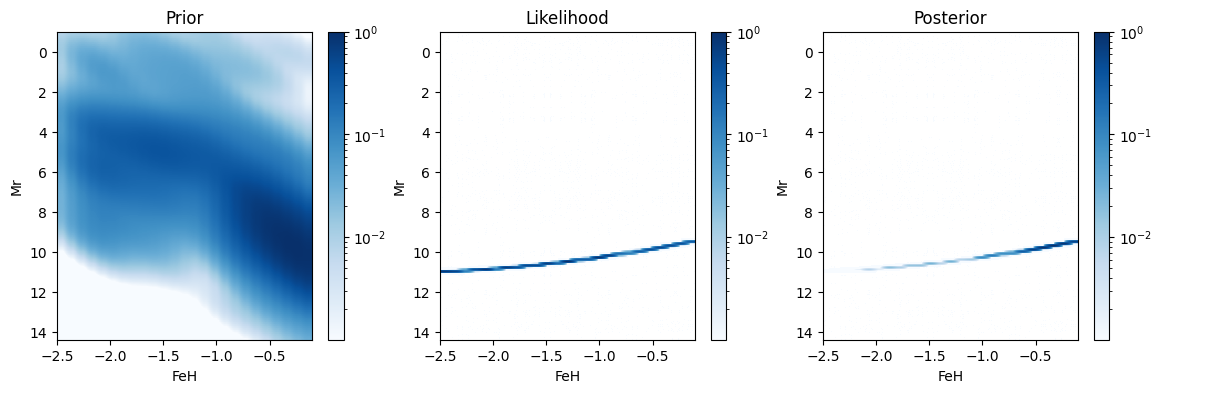

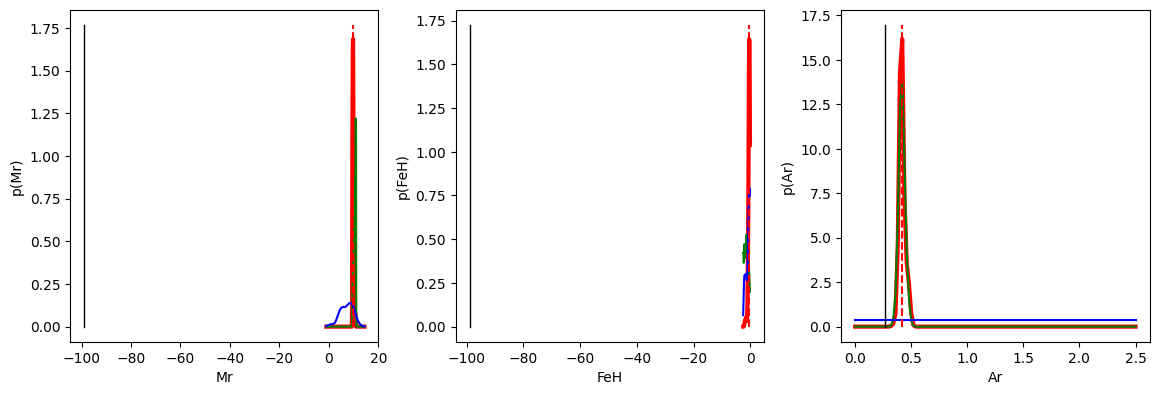

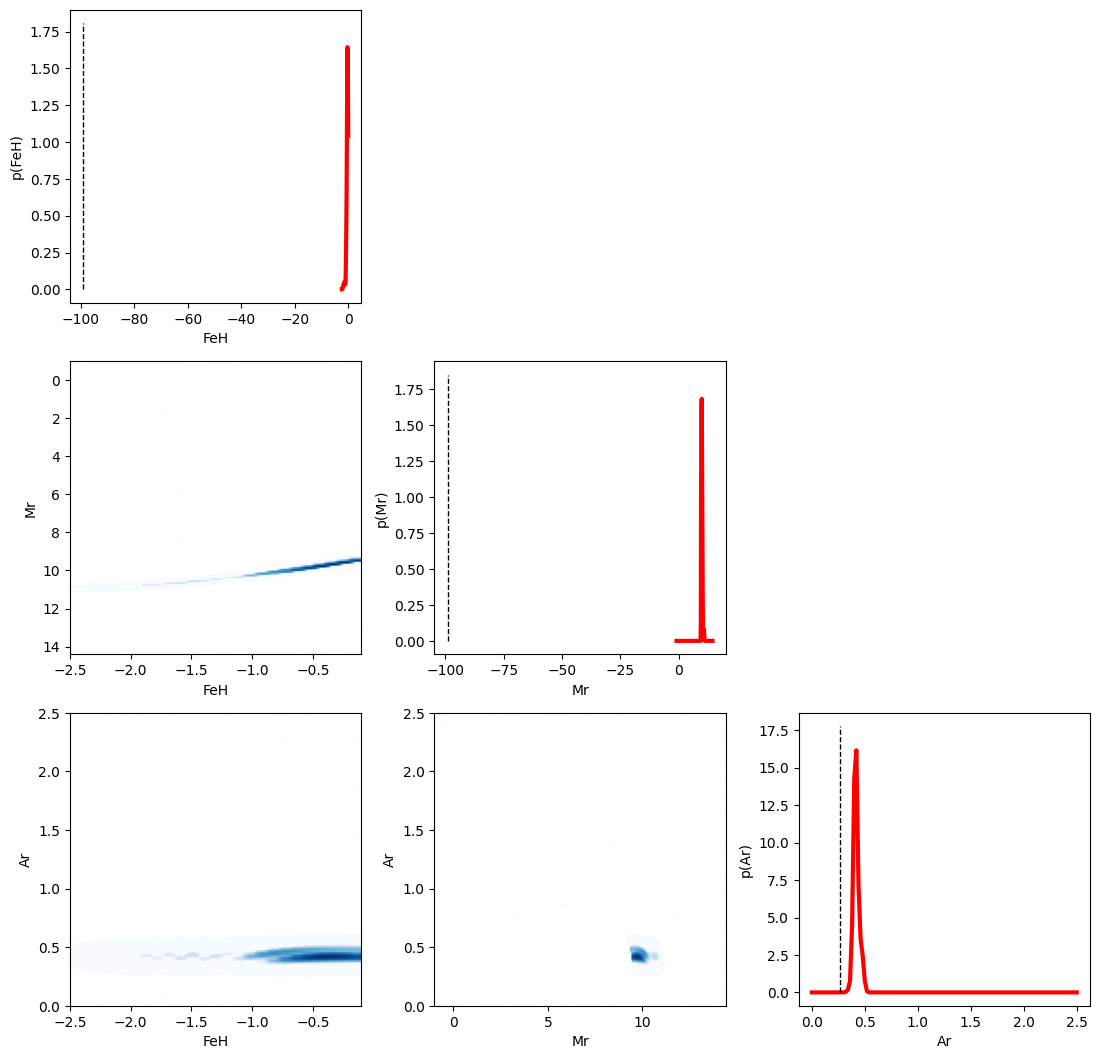

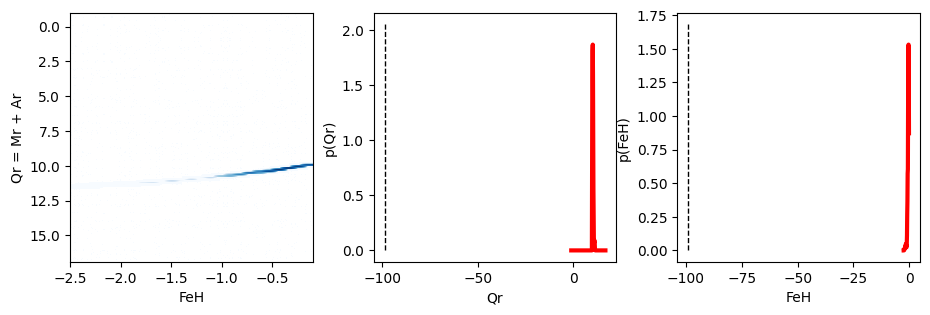

10.286956 0.26310575
Plotting star 1...
pts: 25 155


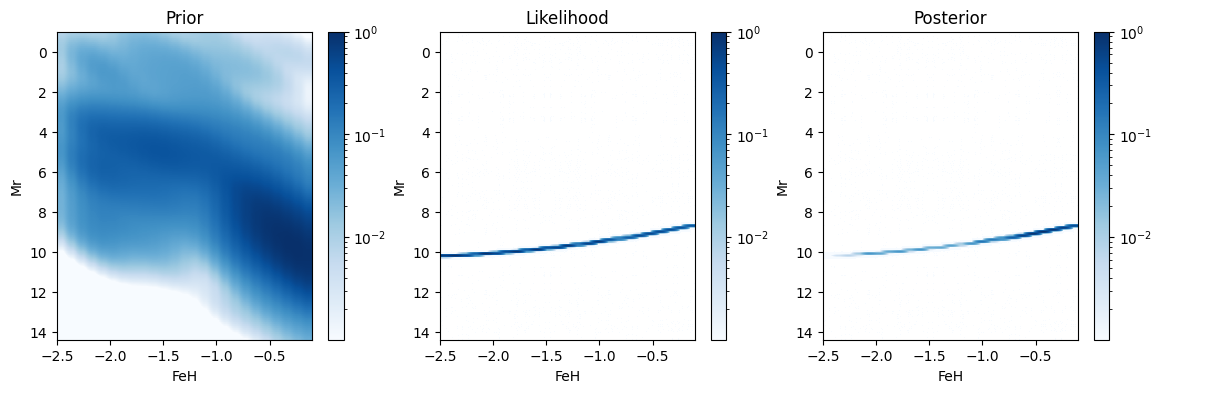

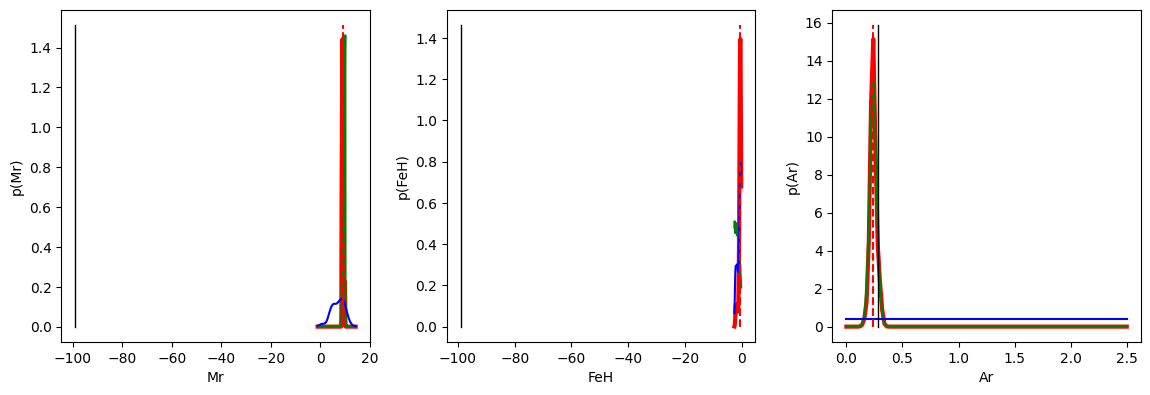

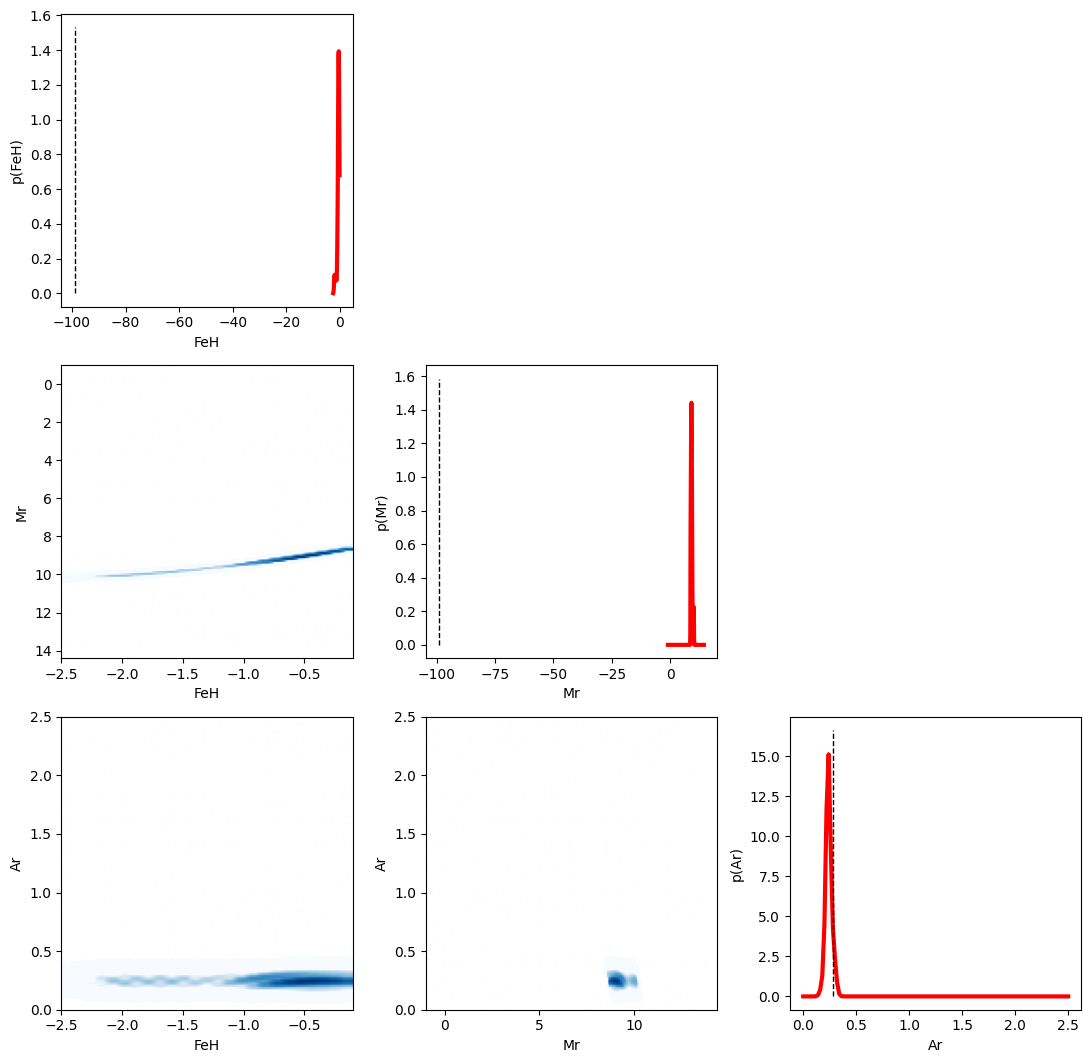

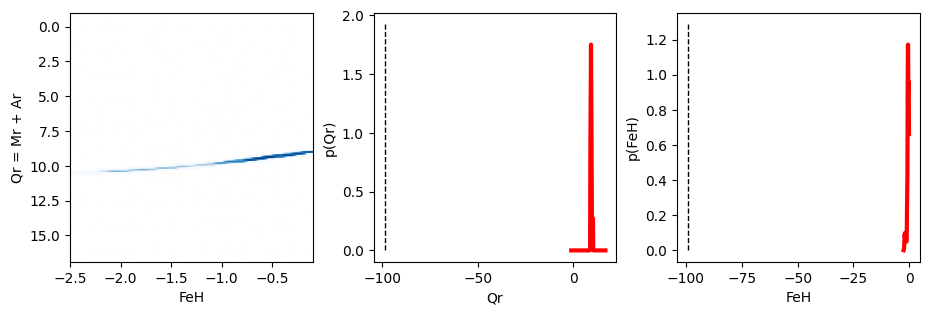

9.448109 0.3383043


In [7]:
# Plot the stars. We provide a DataFrame with the star data, the results
# object and a set of parameters that derive from the global parameters.
plotStars(starDf, bayesResults, *globalParams.getPlottingArgs())

Let's try with yet a different star. We will construct the DataFrame and provide it to the plotting API.

In [8]:
cols = "glon       glat      comp   logg    FeH      Mr      DM      Ar  rmagObs0   ug0     gr0     ri0     iz0    rmag   ugObs   grObs   riObs   izObs   uErr   gErr   rErr   iErr   zErr    ugSL    grSL    riSL    izSL ugErrSL grErrSL riErrSL izErrSL".split()
vals = "66.88731266 -49.16282181    3    4.50  -2.00    5.12   17.85   0.150   23.12   0.777   0.309   0.100   0.046   23.13   0.838   0.369   0.136   0.075  0.059  0.012  0.010  0.012  0.019   0.860   0.380   0.142   0.050   0.061   0.016   0.016   0.023".split()

_ = pd.DataFrame.from_dict({c: [float(v)] for c, v in zip(cols, vals)})

# rmag, ugObs... = generirane iz modela, sa šumom i ekstinkcijom
# greške za boje *Obs treba odrediti iz magnituda

c = SkyCoord(l=_['glon'].to_numpy()*u.degree, b=_['glat'].to_numpy()*u.degree, frame='galactic').transform_to('icrs')
_['ra'] = c.ra
_['dec'] = c.dec

_['ugErr'] = np.sqrt(_['uErr']**2+_['gErr']**2)
_['grErr'] = np.sqrt(_['gErr']**2+_['rErr']**2)
_['riErr'] = np.sqrt(_['rErr']**2+_['iErr']**2)
_['izErr'] = np.sqrt(_['iErr']**2+_['zErr']**2)

_.rename(columns={"ugObs":"ug", "grObs":"gr", "riObs":"ri", "izObs":"iz"}, inplace=True)

star = _["glon glat ra dec FeH Mr DM Ar rmag ug gr ri iz ugErr grErr riErr izErr".split()]
star

,glon,glat,ra,dec,FeH,Mr,DM,Ar,rmag,ug,gr,ri,iz,ugErr,grErr,riErr,izErr
0,66.887313,-49.162822,340.004837,-1.141657,-2.0,5.12,17.85,0.15,23.13,0.838,0.369,0.136,0.075,0.060208,0.01562,0.01562,0.022472


In [9]:
bayesResults = makeBayesPosteriors3d(star, priorMapCatalog, globalParams)

Mr1d= -1.0 14.4 155
MrBright, MrFaint= -1.0 14.4
Plotting star 0...
pts: 25 155


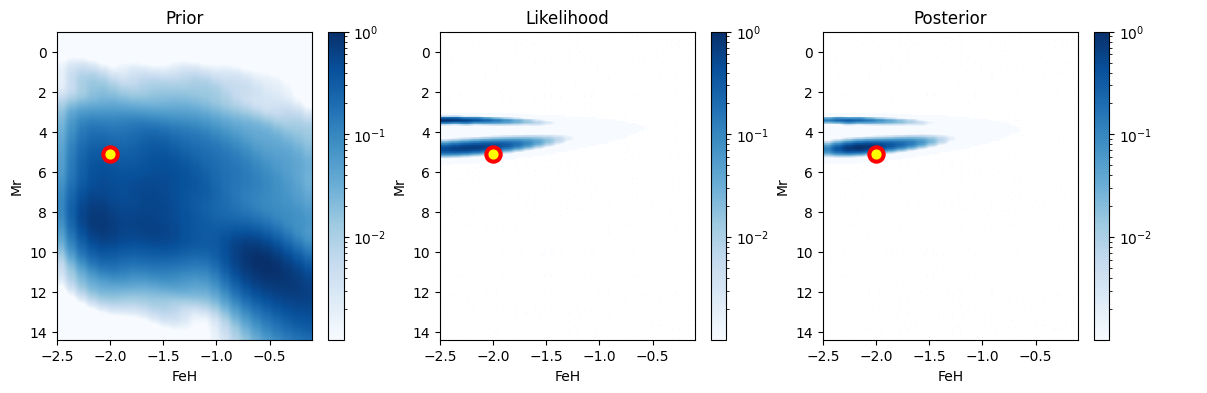

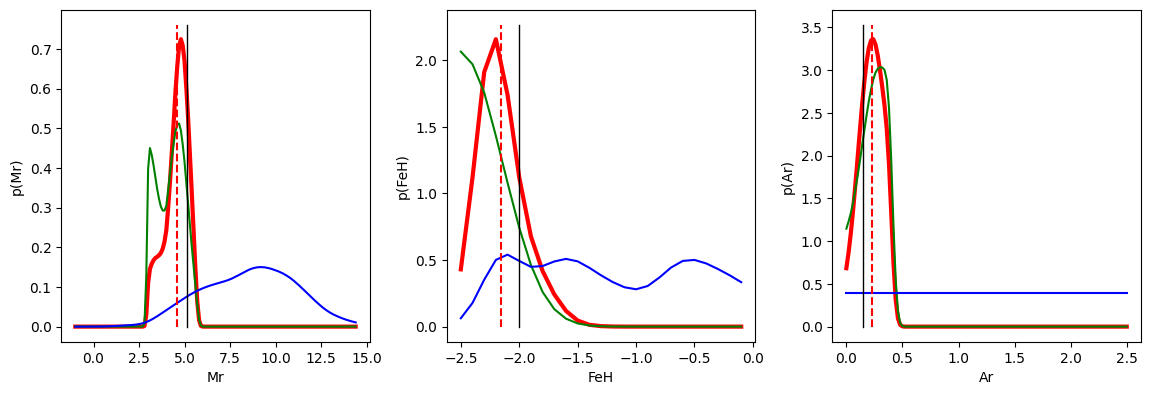

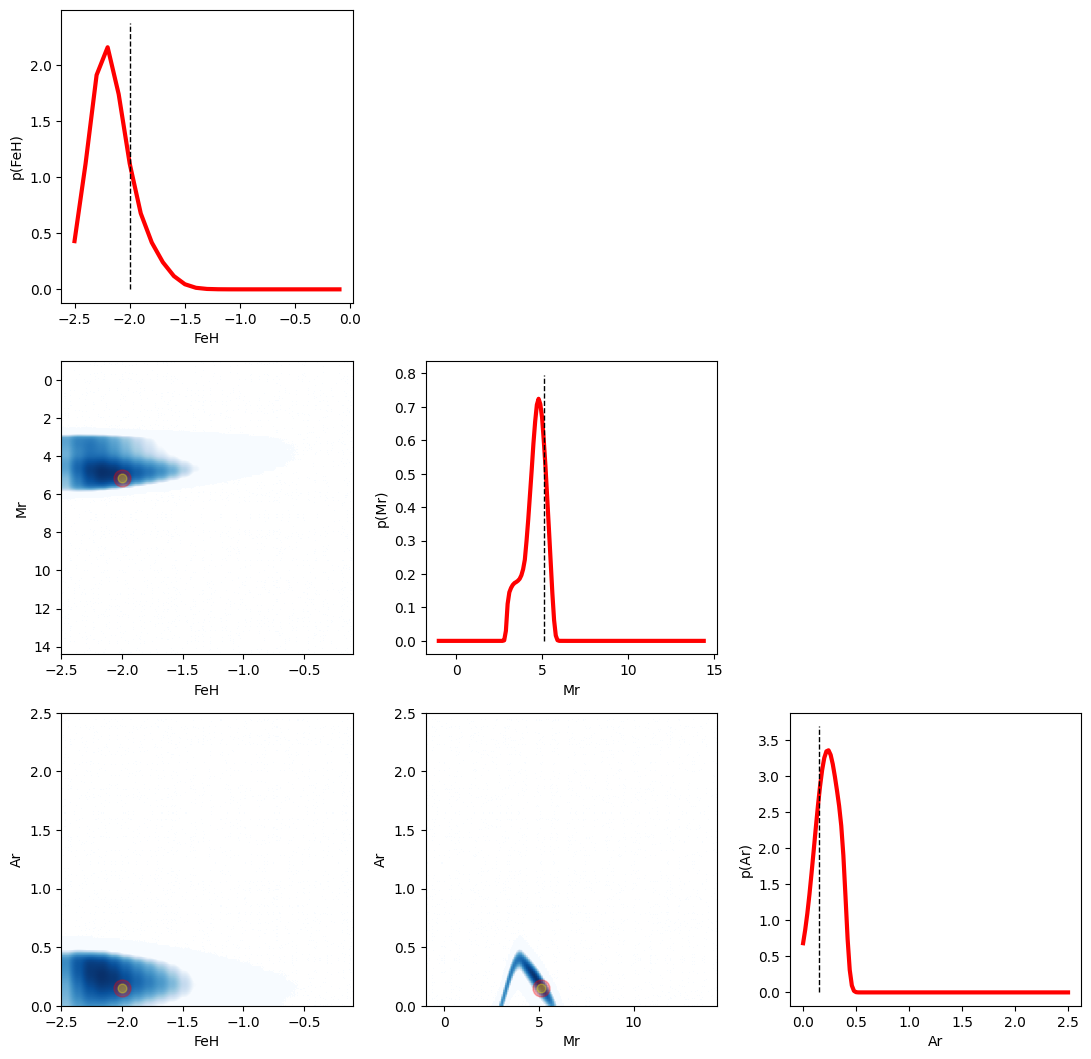

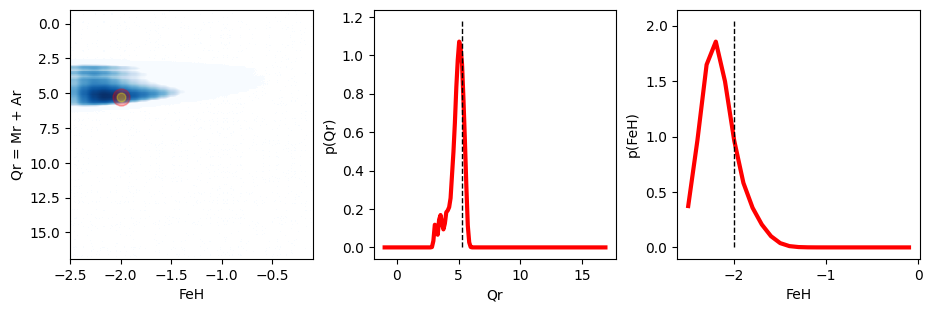

4.8340087 0.59558743


In [10]:
plotStars(star, bayesResults, *globalParams.getPlottingArgs())